In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
from IPython.display import Audio
import matplotlib.pyplot as plt
from tqdm import tqdm

from data import SyntheticNotesDataset
from model import WaveNetAutoencoder, DisentangledWaveNetAE
from train import train_model, train_disentangled
from eval import evaluate_with_pitch_control, evaluate_model, compare_models

# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


Generated note with MIDI pitch: 67


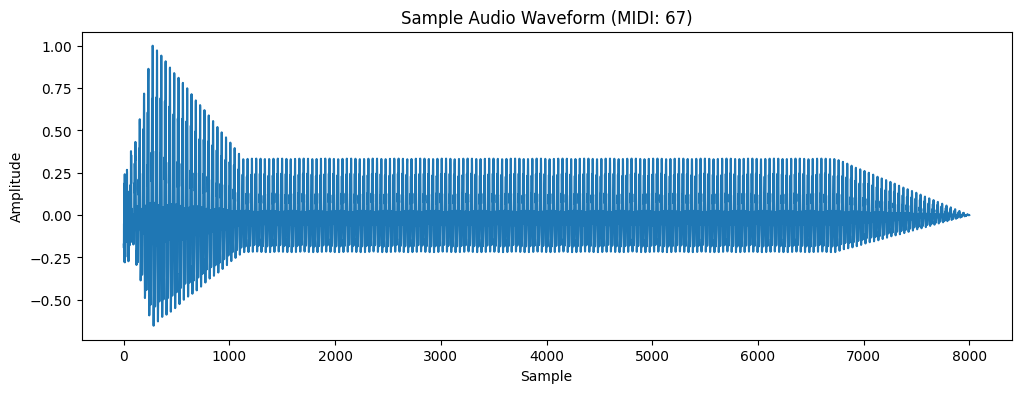

In [8]:
# Create dataset and dataloader
train_dataset = SyntheticNotesDataset(num_samples=10000, duration=0.5)  # 0.5-second notes
val_dataset = SyntheticNotesDataset(num_samples=2000, duration=0.5)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

# Let's listen to a sample
sample_audio, sample_midi = train_dataset[0]
print(f"Generated note with MIDI pitch: {sample_midi.item() + train_dataset.min_midi}")
display(Audio(sample_audio.numpy(), rate=16000))

# Plot the sample
plt.figure(figsize=(12, 4))
plt.plot(sample_audio.numpy())
plt.title(f"Sample Audio Waveform (MIDI: {sample_midi.item() + train_dataset.min_midi})")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.show()

In [3]:
# Initialize model
input_length = 8000  # 0.5 seconds at 16kHz
original_model = WaveNetAutoencoder(input_length=input_length, latent_dim=128, num_dilated_layers=5).to(device)
# original_model.load_state_dict(torch.load('models/wavenet_autoencoder.pth'))

In [4]:
# Training setup
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(original_model.parameters(), lr=0.001)

# Train the model
train_model(original_model, train_dataloader, val_dataloader, optimizer, criterion, num_epochs=5)

Training Progress:  20%|██        | 1/5 [01:06<04:25, 66.49s/it, Batch Loss=0.023997]


Epoch [1/5], Average Loss: 0.040317, Validation Loss: 0.020570


Training Progress:  40%|████      | 2/5 [02:12<03:19, 66.49s/it, Batch Loss=0.010615]


Epoch [2/5], Average Loss: 0.012999, Validation Loss: 0.007503


Training Progress:  60%|██████    | 3/5 [03:19<02:13, 66.51s/it, Batch Loss=0.004649]


Epoch [3/5], Average Loss: 0.005832, Validation Loss: 0.005013


Training Progress:  80%|████████  | 4/5 [04:26<01:06, 66.50s/it, Batch Loss=0.005063]


Epoch [4/5], Average Loss: 0.003907, Validation Loss: 0.003768


Training Progress: 100%|██████████| 5/5 [05:32<00:00, 66.49s/it, Batch Loss=0.003403]


Epoch [5/5], Average Loss: 0.003567, Validation Loss: 0.003374
Training complete!


In [5]:
# Save
torch.save(original_model.state_dict(), 'models/wavenet_autoencoder.pth')

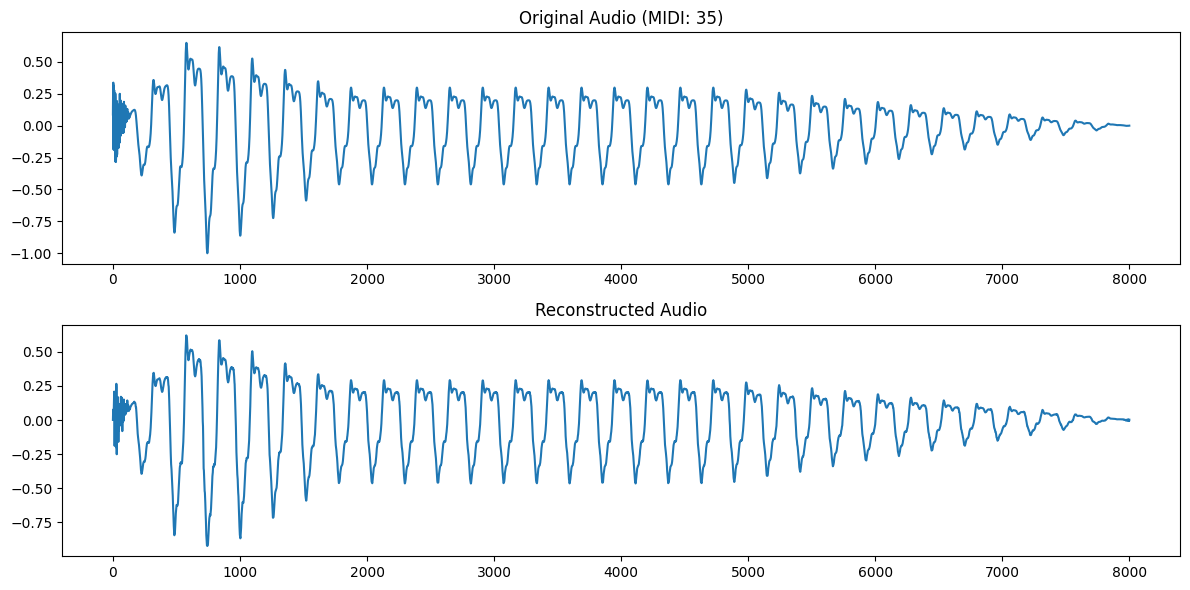

Original:


Reconstructed:


In [6]:
# Evaluate
evaluate_model(original_model, val_dataset, num_samples=1)

In [3]:
# Initialize the enhanced model
disentangled_model = DisentangledWaveNetAE(
    input_length=8000,
    latent_dim=128,
    num_dilated_layers=5,
    bottleneck_dim=32,
    num_pitches=88
).to(device)
#disentangled_model.load_state_dict(torch.load('models/disentangled_wavenet_autoencoder.pth'))

In [4]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(disentangled_model.parameters(), lr=0.001)

# Train the model
train_disentangled(disentangled_model, train_dataloader, val_dataloader, optimizer, criterion, num_epochs=5, adv_weight=0.1, decay=0.01)

Training Progress:  20%|██        | 1/5 [01:22<05:29, 82.35s/it, Recon Loss=0.0236, Pitch Acc=0.00, Adv weight=0.0043]


Epoch 1 Summary:
Reconstruction Loss: 0.067680, Validation Reconstruction Loss: 0.024938
Pitch Prediction Loss: 4.488264, Validation Pitch Prediction Loss: 4.475305
Discriminator Loss: 4.488874, Validation Discriminator Loss: 4.475305


Training Progress:  40%|████      | 2/5 [02:43<04:06, 82.13s/it, Recon Loss=0.0072, Pitch Acc=0.00, Adv weight=0.0002]


Epoch 2 Summary:
Reconstruction Loss: 0.020904, Validation Reconstruction Loss: 0.016284
Pitch Prediction Loss: 4.460493, Validation Pitch Prediction Loss: 4.428740
Discriminator Loss: 4.460505, Validation Discriminator Loss: 4.428740


Training Progress:  60%|██████    | 3/5 [04:06<02:44, 82.13s/it, Recon Loss=0.0049, Pitch Acc=0.00, Adv weight=0.0000]


Epoch 3 Summary:
Reconstruction Loss: 0.010196, Validation Reconstruction Loss: 0.005090
Pitch Prediction Loss: 4.402642, Validation Pitch Prediction Loss: 4.358097
Discriminator Loss: 4.402578, Validation Discriminator Loss: 4.358097


Training Progress:  80%|████████  | 4/5 [05:27<01:22, 82.01s/it, Recon Loss=0.0031, Pitch Acc=0.12, Adv weight=0.0000]


Epoch 4 Summary:
Reconstruction Loss: 0.004992, Validation Reconstruction Loss: 0.004432
Pitch Prediction Loss: 4.325728, Validation Pitch Prediction Loss: 4.291082
Discriminator Loss: 4.325801, Validation Discriminator Loss: 4.291082


Training Progress: 100%|██████████| 5/5 [06:49<00:00, 81.92s/it, Recon Loss=0.0022, Pitch Acc=0.12, Adv weight=0.0000]


Epoch 5 Summary:
Reconstruction Loss: 0.003801, Validation Reconstruction Loss: 0.003876
Pitch Prediction Loss: 4.252527, Validation Pitch Prediction Loss: 4.204563
Discriminator Loss: 4.252471, Validation Discriminator Loss: 4.204563


In [5]:
torch.save(disentangled_model.state_dict(), 'models/disentangled_wavenet_autoencoder.pth')

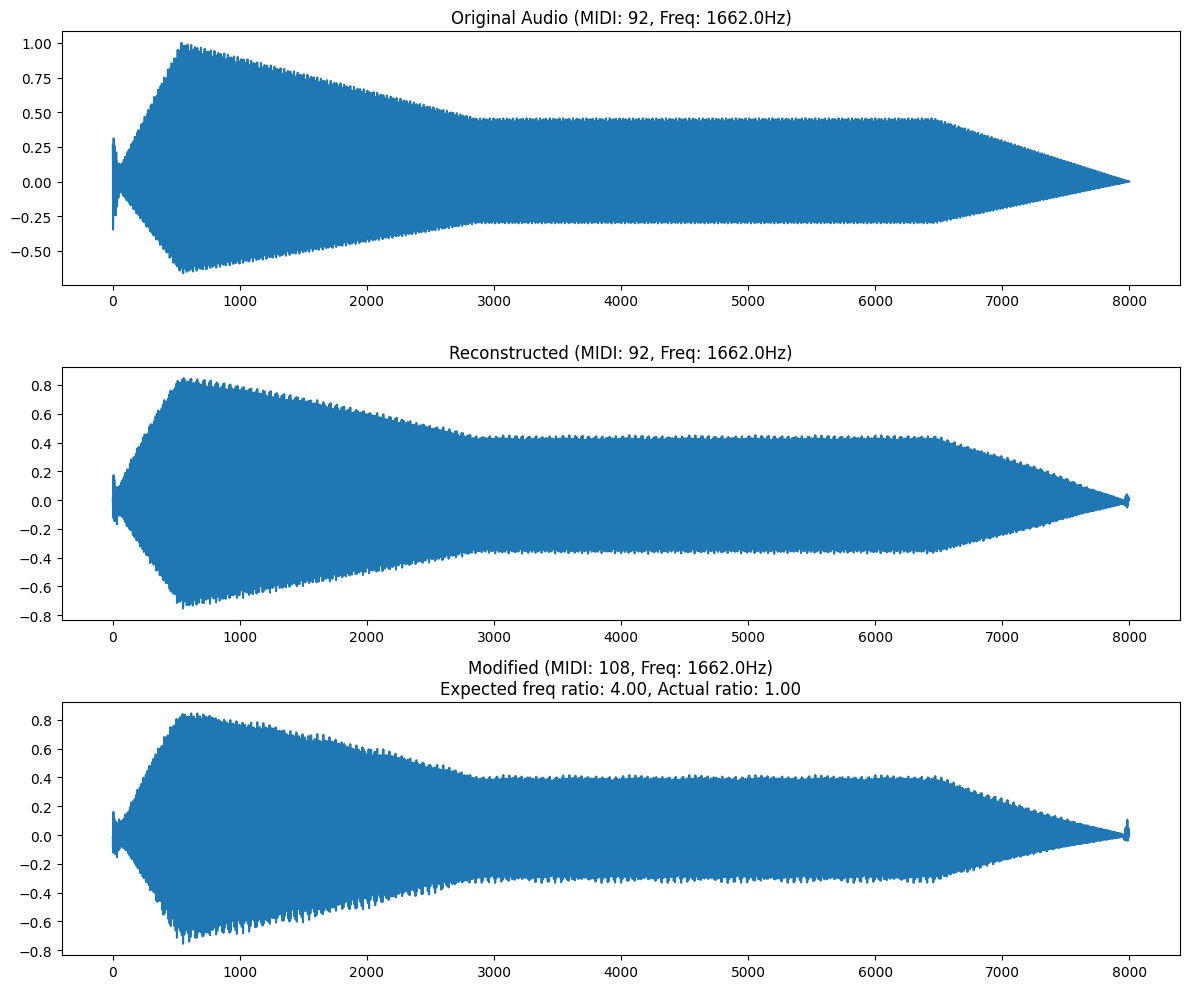

Original:


Reconstructed (same pitch):


Modified (new pitch 108):


In [6]:
# Evaluate with pitch control
evaluate_with_pitch_control(disentangled_model, val_dataset, num_samples=1)

Evaluating reconstruction:   0%|          | 0/10 [00:00<?, ?it/s]


=== Reconstruction Quality ===


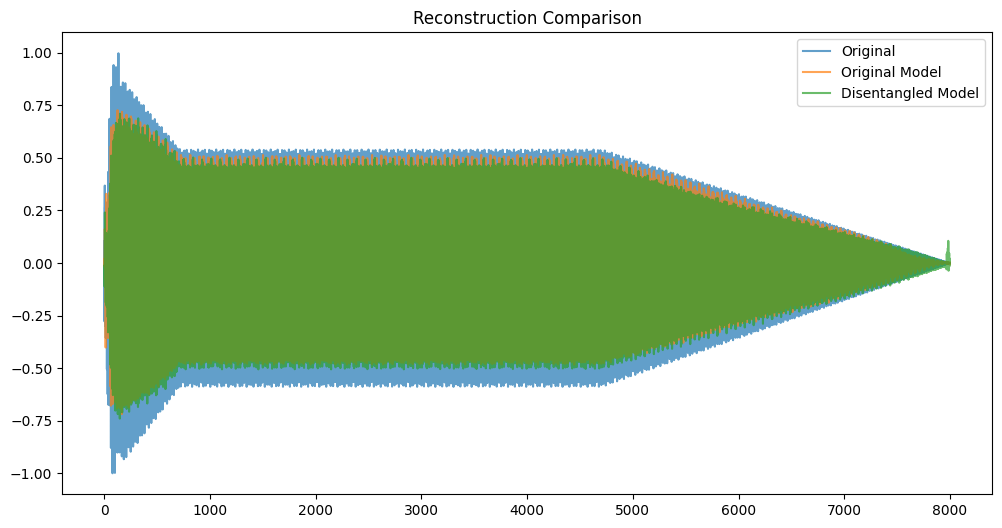

Original Audio:


Original Model Reconstruction:


Disentangled Model Reconstruction:


Evaluating pitch control:   0%|          | 0/10 [00:00<?, ?it/s]


Average Reconstruction Loss:
Original: 0.003701
Disentangled: 0.004454

=== Pitch Control Accuracy ===


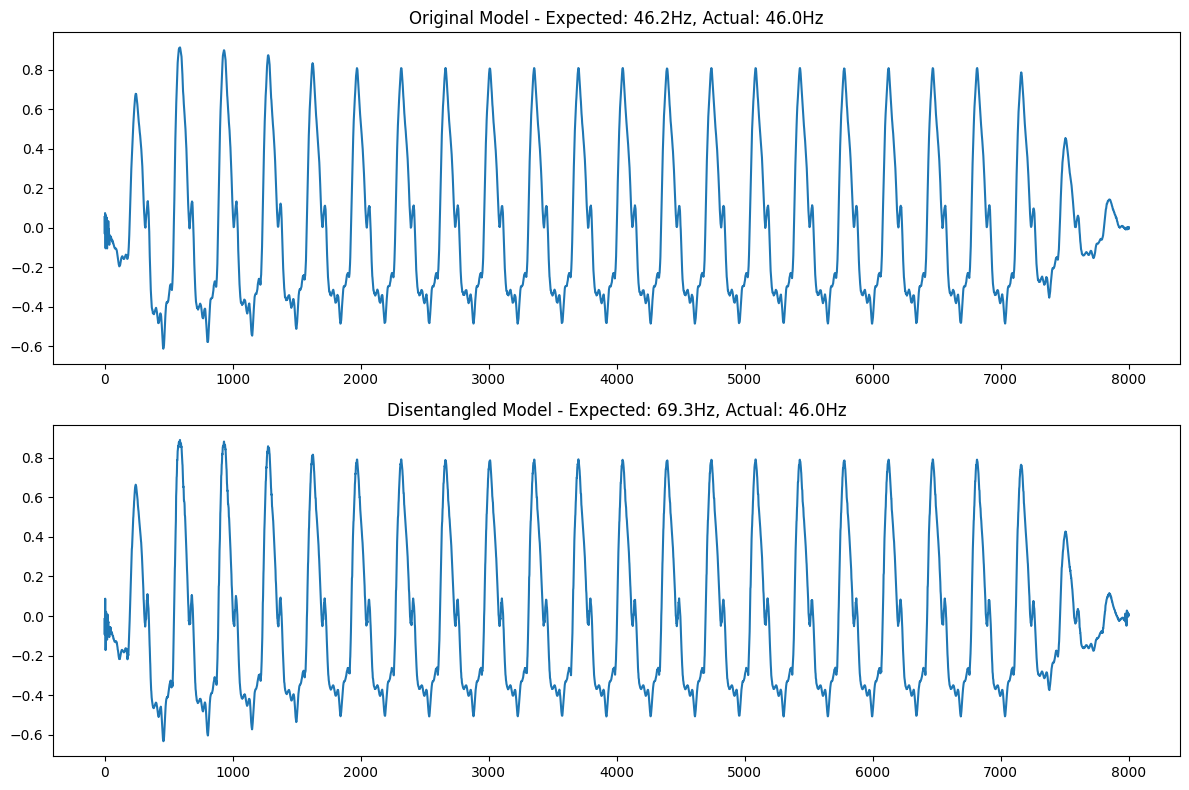

Original Model (no pitch control):


Disentangled Model (with pitch control):


Evaluating timbre preservation:   0%|          | 0/3 [00:00<?, ?it/s]


Pitch Control Accuracy:
Original: 100.0%
Disentangled: 0.0%

=== Timbre Preservation ===


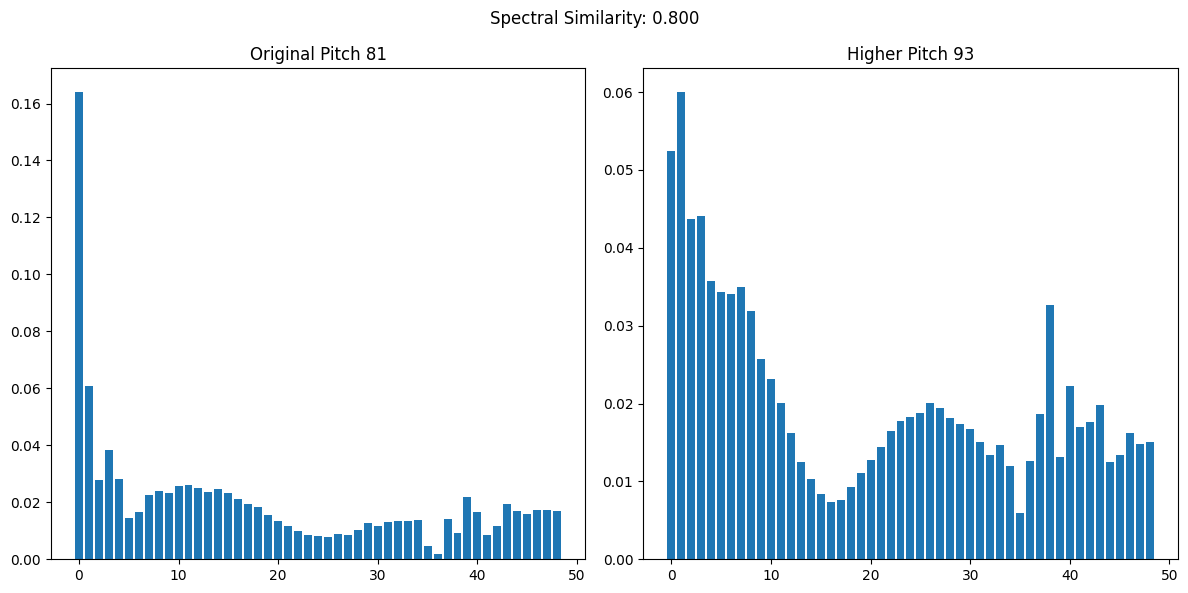

Original Pitch:


Higher Pitch:


Evaluating timbre preservation: 100%|██████████| 3/3 [00:00<00:00,  7.31it/s]


Average Timbre Similarity Across Pitches: 0.907

=== Latent Space Analysis ===

Pitch Information in Latent Space:
Original Model: 0.538
Disentangled Model: 0.466


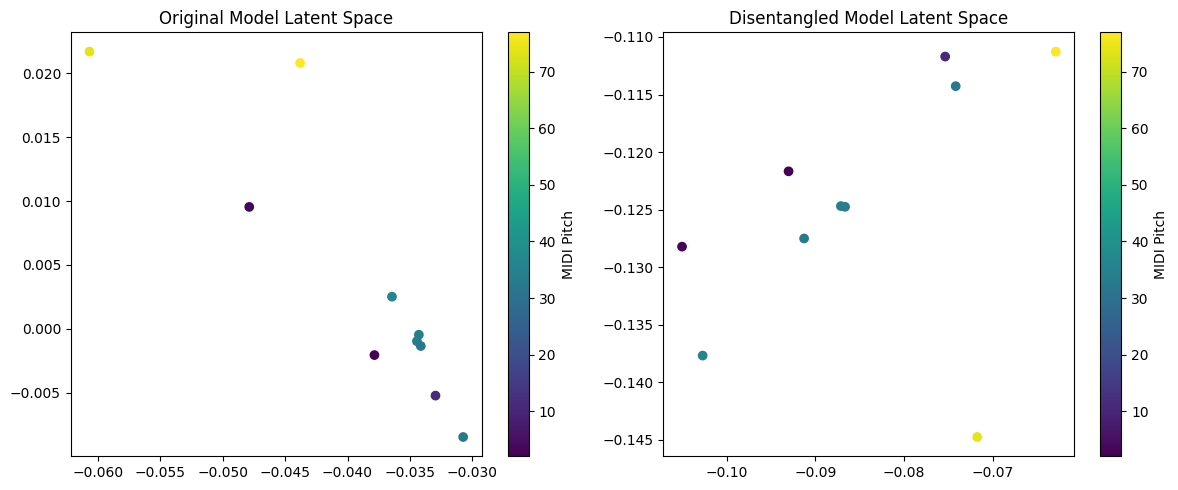


=== Final Comparison Summary ===
1. Reconstruction Quality:
   Original: 0.003701
   Disentangled: 0.004454

2. Pitch Control Accuracy:
   Original: 100.0%
   Disentangled: 0.0%

3. Timbre Preservation:
   Spectral Similarity: 0.907

4. Latent Space Analysis:
   Pitch Correlation in Latent Space:
   Original: 0.538
   Disentangled: 0.466


In [9]:
# Load models (assuming they've been trained and saved)
original_model = WaveNetAutoencoder(input_length=8000).to(device)
original_model.load_state_dict(torch.load('models/wavenet_autoencoder.pth'))

disentangled_model = DisentangledWaveNetAE(input_length=8000).to(device)
disentangled_model.load_state_dict(torch.load('models/disentangled_wavenet_autoencoder.pth'))

# Run comparison
comparison_results = compare_models(original_model, disentangled_model, val_dataset, num_samples=10)

# Print final summary
print("\n=== Final Comparison Summary ===")
print("1. Reconstruction Quality:")
print(f"   Original: {comparison_results['reconstruction_loss']['original']:.6f}")
print(f"   Disentangled: {comparison_results['reconstruction_loss']['disentangled']:.6f}")

print("\n2. Pitch Control Accuracy:")
print(f"   Original: {comparison_results['pitch_accuracy']['original']*100:.1f}%")
print(f"   Disentangled: {comparison_results['pitch_accuracy']['disentangled']*100:.1f}%")

print("\n3. Timbre Preservation:")
print(f"   Spectral Similarity: {comparison_results['timbre_similarity']:.3f}")

print("\n4. Latent Space Analysis:")
print(f"   Pitch Correlation in Latent Space:")
print(f"   Original: {comparison_results['pitch_correlation']['original']:.3f}")
print(f"   Disentangled: {comparison_results['pitch_correlation']['disentangled']:.3f}")